In [8]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

# Introduction
---
For today's tutorial, I will show the demos of tree-base methods.
While taking this tutorial, you can run this notebook step by step.
I will use the python package called *scikit-learn* for models and *pandas* for feature visualization.

---

# Decision Tree

---
In this section, I will show the demo of Decision Tree (DT) to classify the hand-written digits.

---

## Table of Contents
- Data Preparation
- Data Visualization
- Sample Codes
    - Single Tree
    - Bagging Classification
    - Random Forest
- Feature Importance

---

## References
- [Decision Trees](https://scikit-learn.org/stable/modules/tree.html)
- [Bagging Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

---

## Data Preparation
---

In this demo, I will use the same dataset as the previous tutorial, MNIST.
This includes the hand-written digits and mostly used for classification.

---

In [24]:
mnist = fetch_openml("mnist_784", data_home="mnist/")
data_num = 3000
X = mnist.data.values[:data_num]/255
y = np.array(mnist.target.values[:data_num], dtype=np.int)

In [25]:
classes = np.sort(pd.unique(y))
n_samples = X.shape[0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print(f"# of training data : {len(y_train)}")
print(f"# of test data     : {len(y_test)}")

# of training data : 2400
# of test data     : 600


## Data Visualization
---
Since data is originally represented as 2d image, we can visualize it with the reshaping function.
Since some codes are unique to python (numpy) programming, you do not need to obsess with this cell.

---

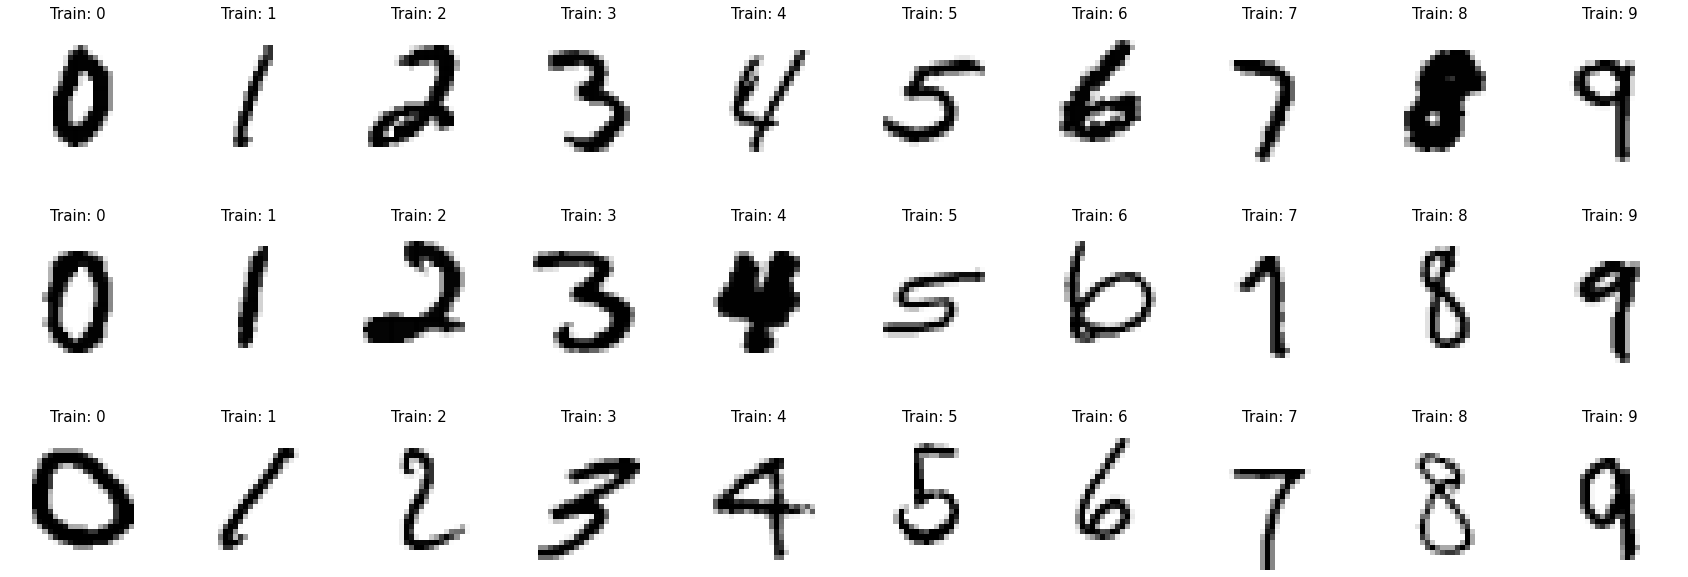

In [26]:
# --- Adjustable Parameters ---

display_num = 3

# -----------------------------

width = len(classes)
length = display_num
fig = plt.figure(figsize=(width*3, length*3.5))
for i in classes:
    images = X_train[y_train==i][:display_num]
    for j in range(display_num):
        ax = fig.add_subplot(length, width, j*width+i+1)
        ax.set_axis_off()
        image = images[j].reshape(28, 28)
        ax.imshow(image, cmap=plt.cm.gray_r)
        ax.set_title(f"Train: {i}", fontsize=15)

## Coding Samples
---
Let's train your own tree models to classify hand-written digits.
Among the models explained in the lesson (please check *DDA3020 Lecture 08 Tree-based methods.pdf*), I will introduce the demos of Single Tree, Bagging Classifier, and Random Forest.
And, since they have tree-related hyperparameters to set, I will conduct a hyper-parameter tuning later in this tutorial.

---

### Single Tree
---
Among hyper-parameters, I will focus on two hyper-parameters: `max_depth` and `min_samples_split` (ppg.52 in the slide).

- Functions
    - `DecisionTreeClassifier`: Define Single Tree.
    

- Hyper-Parameters
    - `max_depth`: The maximum depth of the tree
    - `min_samples_split`: The minimum number of samples required to split an internal node
    
    
---

In [299]:
# --- Adjustable Parameters --- #

max_depth = 8
min_samples_split = 2

# ----------------------------- #
clf = DecisionTreeClassifier(random_state=0,
                             min_samples_split=min_samples_split,
                             max_depth=max_depth
                            )
clf.fit(X_train, y_train)
print(f"Train Accuracy : {clf.score(X_train, y_train)}")
print(f"Test  Accuracy : {clf.score(X_test, y_test)}")

Train Accuracy : 0.8866666666666667
Test  Accuracy : 0.7466666666666667


### Bagging Classifier
---
As explained in the lecture, Bagging Classifier includes multiple classifiers with different sub-training dataset.
We have `n_estimators` to set the \# of classifiers (decision trees).

Note: We can use any classifier for Bagging Classifier (ex. SVC)

- Functions
    - `BaggingClassifier`: Define Bagging Classifier
    

- Hyper-Parameters
    - `n_estimators`: \# of classifiers
    
    
---

In [275]:
# --- Adjustable Parameters --- #

max_depth = 8
min_samples_split = 2
n_estimators = 10

# ----------------------------- #

dt = DecisionTreeClassifier(random_state=0,
                            min_samples_split=min_samples_split,
                            max_depth=max_depth)

clf = BaggingClassifier(base_estimator=dt,
                        n_estimators=n_estimators,
                        random_state=0,
                       )

clf.fit(X_train, y_train)
print(f"Train Accuracy : {clf.score(X_train, y_train)}")
print(f"Test  Accuracy : {clf.score(X_test, y_test)}")

Train Accuracy : 0.9654166666666667
Test  Accuracy : 0.8533333333333334


### Random Forest
---

For Random Forest, it has the same hyper-parameters as Bagging Classifier but expected to be better than that.

- Functions
    - `RandomForestClassifier`: Define Random Forest
    
---

In [276]:
# --- Adjustable Parameters --- #

max_depth = 8
min_samples_split = 2
n_estimators = 10

# ----------------------------- #

clf = RandomForestClassifier(random_state=0,
                             n_estimators=n_estimators,
                             min_samples_split=min_samples_split,
                             max_depth=max_depth,
                            )

clf.fit(X_train, y_train)
print(f"Train Accuracy : {clf.score(X_train, y_train)}")
print(f"Test  Accuracy : {clf.score(X_test, y_test)}")

Train Accuracy : 0.96125
Test  Accuracy : 0.8766666666666667


## Hyper-Parameters Tuning
---

As explained in the lesson, tree-based models are vulnerable to overfitting.
So, we need to find better hyperparameters (high accuracy and weaker overfitting) via hyper-parameters tuning.
Since the grid search requires much time to process, I will use Randomized Search used in the last tutorial.

`cv` in arguments of `RandomizedSearchCV` indicates the $k$ in [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html).

- Hyper-Parameters
    - `max_depth`: The maximum depth of the tree
    - `min_samples_split`: The minimum number of samples required to split an internal node
    
---
### Single Tree

---

In [302]:
models = {}
dt = DecisionTreeClassifier(random_state=0)
distributions = dict(
    max_depth=np.arange(5, 31),
    min_samples_split=2**np.arange(0, 4),
)

# Random Search

clf = RandomizedSearchCV(dt, distributions, random_state=0, n_iter=20, cv=3, n_jobs=-1)
search = clf.fit(X_train, y_train)
best_params = search.best_params_
print("Best Parameters:")
for key in best_params:
    print(f"    {key}: {best_params[key]}")
    
# Classification with Best Parameters
    
st = DecisionTreeClassifier(random_state=0,
                             min_samples_split=best_params["min_samples_split"],
                             max_depth=best_params["max_depth"]
                            )
st.fit(X_train, y_train)
models["single tree"] = st

print()
print(f"Train Accuracy : {st.score(X_train, y_train)}")
print(f"Test  Accuracy : {st.score(X_test, y_test)}")

Best Parameters:
    min_samples_split: 4
    max_depth: 20

Train Accuracy : 0.9729166666666667
Test  Accuracy : 0.7583333333333333


### Bagging Classifier

In [303]:
dt = DecisionTreeClassifier(random_state=0)
bc = BaggingClassifier(base_estimator=dt,
                        n_estimators=10,
                        random_state=0)

distributions = dict(
    base_estimator__max_depth=np.arange(5, 31),
    base_estimator__min_samples_split=2**np.arange(0, 4),
)

# Random Search

clf = RandomizedSearchCV(bc, distributions, random_state=0, n_iter=20, cv=3, n_jobs=-1)
search = clf.fit(X_train, y_train)
best_params = search.best_params_
print("Best Parameters:")
for key in best_params:
    print(f"    {key}: {best_params[key]}")
    
# Classification with Best Parameters

dt = DecisionTreeClassifier(random_state=0,
                             min_samples_split=best_params["base_estimator__min_samples_split"],
                             max_depth=best_params["base_estimator__max_depth"])

bc = BaggingClassifier(base_estimator=dt,
                        n_estimators=10,
                        random_state=0)

bc.fit(X_train, y_train)
models["bagging"] = bc

print()
print(f"Train Accuracy : {bc.score(X_train, y_train)}")
print(f"Test  Accuracy : {bc.score(X_test, y_test)}")

Best Parameters:
    base_estimator__min_samples_split: 4
    base_estimator__max_depth: 11

Train Accuracy : 0.9925
Test  Accuracy : 0.875


### Random Forest

In [308]:
rf = RandomForestClassifier(random_state=0,
                             n_estimators=10)
distributions = dict(
    max_depth=np.arange(5, 31),
    min_samples_split=2**np.arange(0, 4),
)

# Random Search

clf = RandomizedSearchCV(rf, distributions, random_state=0, n_iter=20, cv=3, n_jobs=-1)
search = clf.fit(X_train, y_train)
best_params = search.best_params_
print("Best Parameters:")
for key in best_params:
    print(f"    {key}: {best_params[key]}")
    
# Classification with Best Parameters
    
rf = RandomForestClassifier(random_state=0,
                            n_estimators=10,
                             min_samples_split=best_params["min_samples_split"],
                             max_depth=best_params["max_depth"]
                            )
rf.fit(X_train, y_train)
models["random forest"] = rf

print()
print(f"Train Accuracy : {rf.score(X_train, y_train)}")
print(f"Test  Accuracy : {rf.score(X_test, y_test)}")

Best Parameters:
    min_samples_split: 4
    max_depth: 12

Train Accuracy : 0.9945833333333334
Test  Accuracy : 0.9016666666666666


## Feature Importance
---
One of other advantages of using tree-based models is its interpretability.
In other words, We can easily understand how the models process data.
Among them, I will introduce feature importance, which shows how each feature (in our case, pixels of images) affects the result.

- New Attributes
    - `feature_importances_`: feature importance of each feature
    
---
### Single Tree

---

In [317]:
model = models["single tree"]

fi = model.feature_importances_
fi_df = pd.DataFrame([np.array([f"pixel-({i//28}, {i%28})" for i in range(784)]), fi], index=["name", "importance"]).T
fi_df["importance"] = fi_df["importance"].values.astype("float")

fi_df.sort_values(by="importance", ascending=False)

name  importance
455   pixel-(16, 7)    0.054454
101   pixel-(3, 17)    0.049829
433  pixel-(15, 13)    0.048679
401   pixel-(14, 9)    0.046974
319  pixel-(11, 11)    0.037186
..              ...         ...
275   pixel-(9, 23)    0.000000
277   pixel-(9, 25)    0.000000
278   pixel-(9, 26)    0.000000
279   pixel-(9, 27)    0.000000
783  pixel-(27, 27)    0.000000

[784 rows x 2 columns]

### Bagging Classifier

In [270]:
model = models["bagging"]

fi = np.zeros((784))
for tree in model.estimators_:
    fi += tree.feature_importances_
fi = fi/len(model.estimators_)
fi_df = pd.DataFrame([np.array([f"pixel-({i//28}, {i%28})" for i in range(784)]), fi], index=["name", "importance"]).T
fi_df["importance"] = fi_df["importance"].values.astype("float")

fi_df.sort_values(by="importance", ascending=False)

name  importance
101   pixel-(3, 17)    0.044064
211   pixel-(7, 15)    0.038646
377  pixel-(13, 13)    0.032051
271   pixel-(9, 19)    0.026425
455   pixel-(16, 7)    0.025969
..              ...         ...
252    pixel-(9, 0)    0.000000
251   pixel-(8, 27)    0.000000
250   pixel-(8, 26)    0.000000
244   pixel-(8, 20)    0.000000
783  pixel-(27, 27)    0.000000

[784 rows x 2 columns]

### Random Forest

In [271]:
model = models["random forest"]

fi = model.feature_importances_
fi_df = pd.DataFrame([np.array([f"pixel-({i//28}, {i%28})" for i in range(784)]), fi], index=["name", "importance"]).T
fi_df["importance"] = fi_df["importance"].values.astype("float")

fi_df.sort_values(by="importance", ascending=False)

name  importance
409  pixel-(14, 17)    0.011869
541   pixel-(19, 9)    0.011469
430  pixel-(15, 10)    0.010728
350  pixel-(12, 14)    0.010294
373   pixel-(13, 9)    0.009845
..              ...         ...
255    pixel-(9, 3)    0.000000
254    pixel-(9, 2)    0.000000
253    pixel-(9, 1)    0.000000
252    pixel-(9, 0)    0.000000
783  pixel-(27, 27)    0.000000

[784 rows x 2 columns]

### 2d Representation of Feature Importance
---

Of course, the feature name of MNIST is not intuitive, so let's visualize it in 2d-representation.

---

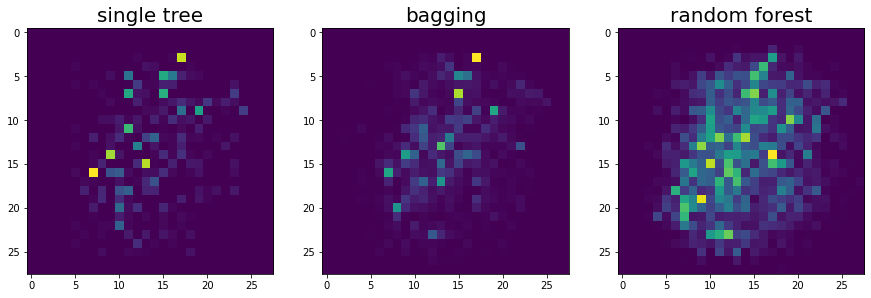

In [153]:
width = len(models)
length = 1

fig = plt.figure(figsize=(width*5, length*5.5))

for i, name in enumerate(models):
    if name in ["bagging"]:
        fi = np.zeros((784))
        for tree in models[name].estimators_:
            fi += tree.feature_importances_
        fi = fi/len(models[name].estimators_)
    else:
        fi = models[name].feature_importances_
    ax = fig.add_subplot(length, width, i+1)
    ax.imshow(fi.reshape(28, 28))
    ax.set_title(name, fontsize=20)

### Let's Observe the Validity of Feature Importance
---
Let's modify the values of the *un-important* features and the *important* features; and see the result.


---

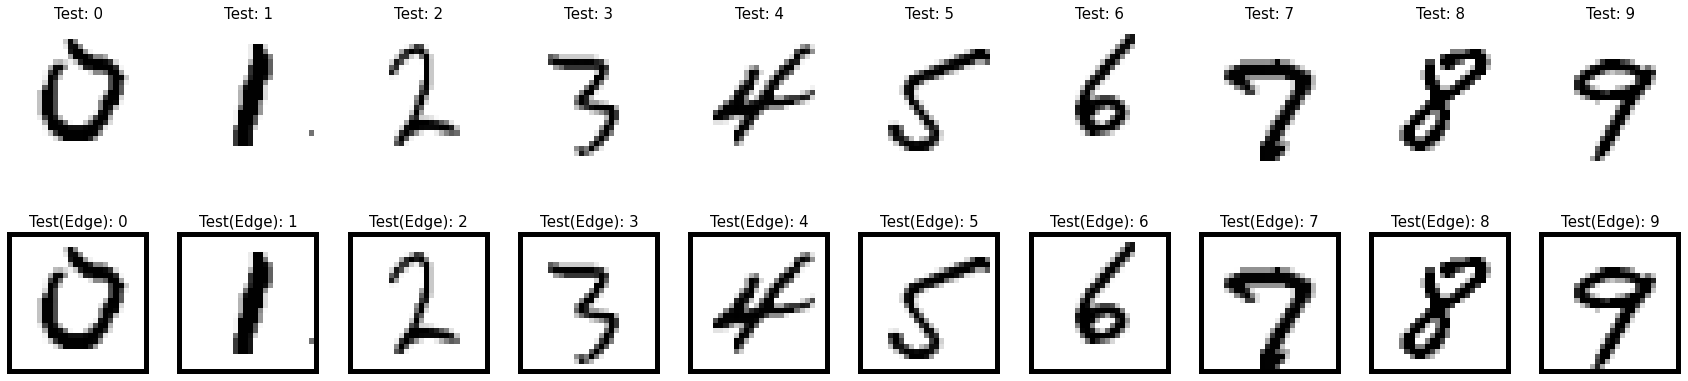

In [223]:
frame = np.zeros((28, 28))
frame[[0,-1],:] = 1
frame[:, [0,-1]] = 1
X_test_edge = X_test + frame.reshape(1, 784)
X_test_edge[X_test_edge>1] = 1

width = len(classes)
length = 2
fig = plt.figure(figsize=(width*3, length*3.5))
for i in classes:
    images = X_test[y_test==i][:1]
    ax = fig.add_subplot(length, width, i+1)
    ax.set_axis_off()
    image = images[0].reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(f"Test: {i}", fontsize=15)
    
    images = X_test_edge[y_test==i][:1]
    ax = fig.add_subplot(length, width, width+i+1)
    ax.set_axis_off()
    image = images[0].reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(f"Test(Edge): {i}", fontsize=15)

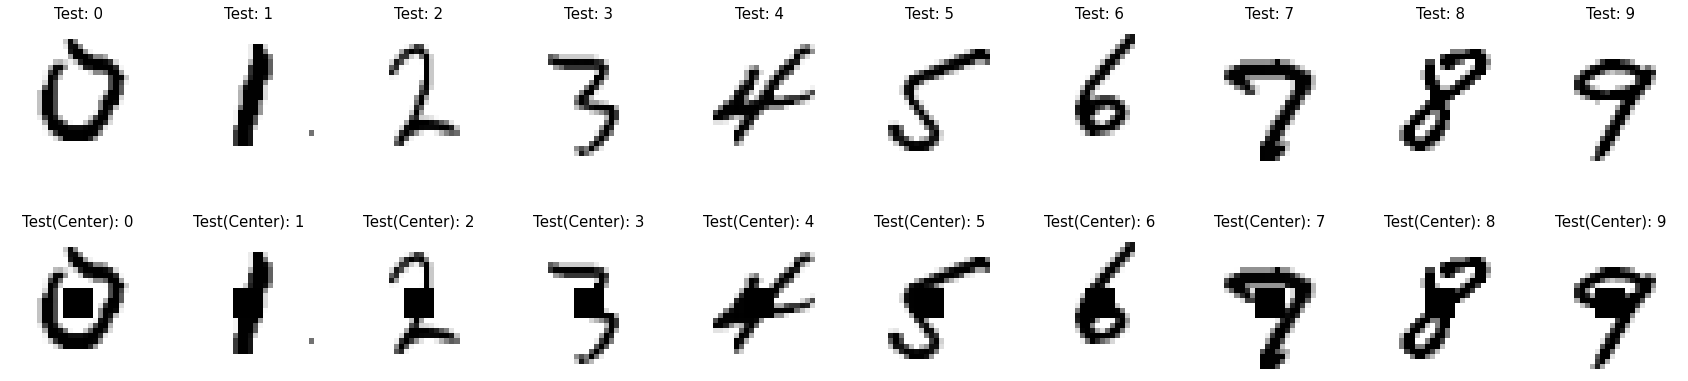

In [224]:
frame = np.zeros((28, 28))
frame = np.zeros((28, 28))
frame[11:17,11:17] = 1
X_test_center = X_test + frame.reshape(1, 784)
X_test_center[X_test_center>1] = 1

width = len(classes)
length = 2
fig = plt.figure(figsize=(width*3, length*3.5))
for i in classes:
    images = X_test[y_test==i][:1]
    ax = fig.add_subplot(length, width, i+1)
    ax.set_axis_off()
    image = images[0].reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(f"Test: {i}", fontsize=15)
    
    images = X_test_center[y_test==i][:1]
    ax = fig.add_subplot(length, width, width+i+1)
    ax.set_axis_off()
    image = images[0].reshape(28, 28)
    ax.imshow(image, cmap=plt.cm.gray_r)
    ax.set_title(f"Test(Center): {i}", fontsize=15)

In [306]:
for i, name in enumerate(models):
    print(f"Classifier: {name}")
    print(f"    Original Test Accuracy: {models[name].score(X_test, y_test)}")
    print(f"    Edge     Test Accuracy: {models[name].score(X_test_edge, y_test)}")
    print(f"    Center   Test Accuracy: {models[name].score(X_test_center, y_test)}")
    print()

Classifier: single tree
    Original Test Accuracy: 0.7583333333333333
    Edge     Test Accuracy: 0.7583333333333333
    Center   Test Accuracy: 0.32

Classifier: bagging
    Original Test Accuracy: 0.875
    Edge     Test Accuracy: 0.875
    Center   Test Accuracy: 0.5566666666666666

Classifier: random forest
    Original Test Accuracy: 0.9016666666666666
    Edge     Test Accuracy: 0.9016666666666666
    Center   Test Accuracy: 0.6916666666666667

